#  Обнаружение объектов

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
* https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/
* https://pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/

## Задачи для совместного разбора

1\. Рассмотрите простейшую архитектуру для решения задачи object detection и процесс настройки модели.

## Задачи для самостоятельного решения

In [ ]:
import zipfile
from pathlib import Path

BASE_PATH = Path("/content")
ZIP_PATH = BASE_PATH / "animals.zip"
EXTRACT_ROOT = BASE_PATH / "animals_extracted"

EXTRACT_ROOT.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_ROOT)

ROOT_DIR = EXTRACT_ROOT / "Asirra: cat vs dogs"
print(ROOT_DIR)


/content/animals_extracted/Asirra: cat vs dogs


<p class="task" id="1"></p>

1\. Напишите функцию `parse_xml`, которая читает xml-файл с разметкой изображения из архива `animals.zip` и возвращает словарь, содержащий три ключа:
```
{
        "raw": # словарь с ключами xmin, ymin, xmax, ymax
        "scaled": # словарь с ключами xmin, ymin, xmax, ymax
        "obj_name": # строка
}
```
В этом словаре `row` - абсолютные значения координат вершин bounding box, а `scaled` - относительные (нормированные на ширину и высоту изображения). Примените функцию к файлу `cat.0.xml` и выведите результат на экран.


- [ ] Проверено на семинаре

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
def parse_xml(xml_path):
    xml_path = Path(xml_path)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    size = root.find("size")
    width = float(size.find("width").text)
    height = float(size.find("height").text)

    obj = root.find("object")
    obj_name = obj.find("name").text

    bndbox = obj.find("bndbox")
    xmin = float(bndbox.find("xmin").text)
    ymin = float(bndbox.find("ymin").text)
    xmax = float(bndbox.find("xmax").text)
    ymax = float(bndbox.find("ymax").text)

    raw = {
        "xmin": xmin,
        "ymin": ymin,
        "xmax": xmax,
        "ymax": ymax,
    }

    scaled = {
        "xmin": xmin / width,
        "ymin": ymin / height,
        "xmax": xmax / width,
        "ymax": ymax / height,
    }

    return {
        "raw": raw,
        "scaled": scaled,
        "obj_name": obj_name,
    }

In [ ]:
cat0_xml = ROOT_DIR / "cat.0.xml"
res_cat0 = parse_xml(cat0_xml)
print(res_cat0)

{'raw': {'xmin': 126.0, 'ymin': 83.0, 'xmax': 354.0, 'ymax': 243.0}, 'scaled': {'xmin': 0.252, 'ymin': 0.22192513368983957, 'xmax': 0.708, 'ymax': 0.6497326203208557}, 'obj_name': 'cat'}


<p class="task" id="2"></p>

2\. Опишите датасет `AnimalDetectionDataset` на основе архива `animals.zip`. Реализуйте `__getitem__` таким образом, чтобы он возвращал три элемента: тензор с изображением, словарь с координатами bounding box и метку объекта. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений, преобразование для метки объекта (для кодирования) и флаг, показывающий, нужно ли возвращать исходные или нормированные координаты bounding box.

- [ ] Проверено на семинаре

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

In [ ]:
class AnimalDetectionDataset(Dataset):
    def __init__(self, root, transforms=None, target_transform=None, return_scaled=True):
        self.root = Path(root)
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled

        self.xml_files = sorted(self.root.glob("*.xml"))

    def __len__(self):
        return len(self.xml_files)

    def __getitem__(self, idx):
        xml_path = self.xml_files[idx]
        parsed = parse_xml(xml_path)

        bbox = parsed["scaled"] if self.return_scaled else parsed["raw"]

        img_path = xml_path.with_suffix(".jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)
        else:
            image = transforms.ToTensor()(image)

        label = parsed["obj_name"]
        if self.target_transform is not None:
            label = self.target_transform(label)

        return image, bbox, label

In [ ]:
dataset_debug = AnimalDetectionDataset(ROOT_DIR, return_scaled=True)
print("Длина датасета:", len(dataset_debug))
img0, bbox0, label0 = dataset_debug[0]
print("Пример:", img0.shape, bbox0, label0)

Длина датасета: 1100
Пример: torch.Size([3, 374, 500]) {'xmin': 0.252, 'ymin': 0.22192513368983957, 'xmax': 0.708, 'ymax': 0.6497326203208557} cat


<p class="task" id="3"></p>

3\. Создайте объект класса `AnimalDetectionDataset` без применения преобразований и со значением `return_scaled=False`. Напишите функцию `show_image_with_bounding_box` для визуализации изображения с добавлением на него bounding box и подписи объекта. Продемонстрируйте работу функцию на изображении собаки и кошки.

- [ ] Проверено на семинаре

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path

In [ ]:
dataset_vis = AnimalDetectionDataset(
    ROOT_DIR,
    transforms=None,
    target_transform=None,
    return_scaled=False
)

In [ ]:
def show_image_with_bounding_box(image, bbox, label, is_scaled=False):
    if isinstance(image, torch.Tensor):
        img = image.detach().cpu().permute(1, 2, 0).numpy()
    else:
        img = np.array(image)

    H, W = img.shape[:2]

    if is_scaled:
        xmin = bbox["xmin"] * W
        ymin = bbox["ymin"] * H
        xmax = bbox["xmax"] * W
        ymax = bbox["ymax"] * H
    else:
        xmin = bbox["xmin"]
        ymin = bbox["ymin"]
        xmax = bbox["xmax"]
        ymax = bbox["ymax"]

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(img)
    rect = Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=2,
        edgecolor="red",
        facecolor="none"
    )
    ax.add_patch(rect)
    ax.text(
        xmin,
        max(ymin - 5, 0),
        label,
        fontsize=12,
        color="red",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
    )
    ax.axis("off")
    plt.show()

In [ ]:
xml_files = dataset_vis.xml_files

cat_xml = ROOT_DIR / "cat.0.xml"
dog_xml = ROOT_DIR / "dog.0.xml"

cat_idx = xml_files.index(cat_xml)
dog_idx = xml_files.index(dog_xml)

print("cat_idx:", cat_idx, "dog_idx:", dog_idx)

cat_idx: 0 dog_idx: 550


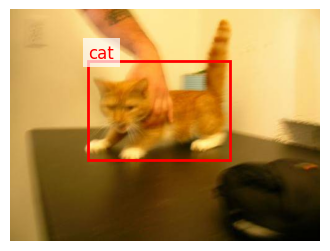

In [ ]:
img_cat, bbox_cat, label_cat = dataset_vis[cat_idx]
show_image_with_bounding_box(img_cat, bbox_cat, label_cat, is_scaled=False)

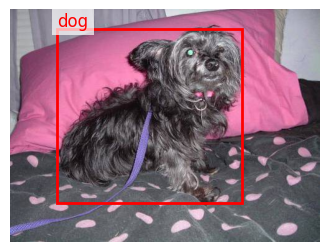

In [ ]:
img_dog, bbox_dog, label_dog = dataset_vis[dog_idx]
show_image_with_bounding_box(img_dog, bbox_dog, label_dog, is_scaled=False)

<p class="task" id="4"></p>

4\. Напишите модель для решения задачи выделения объектов. Реализуйте двухголовую сеть, одна голова которой предсказывает метку объекта (задача классификации), а вторая голова предсказывает 4 координаты вершин bounding box (задача регрессии). В качестве backbone используйте модель resnet50 из пакета `torchvision`.

- [ ] Проверено на семинаре

In [ ]:
import torch.nn as nn
from torchvision import models

In [ ]:
class AnimalDetector(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        in_features = self.backbone.fc.in_features

        self.backbone.fc = nn.Identity()

        self.cls_head = nn.Linear(in_features, num_classes)
        self.box_head = nn.Linear(in_features, 4)

    def forward(self, x):
        features = self.backbone(x)
        logits = self.cls_head(features)
        bbox = torch.sigmoid(self.box_head(features))
        return logits, bbox

In [ ]:
num_classes = 2
model = AnimalDetector(num_classes)
x_test = torch.randn(2, 3, 224, 224)
logits_test, bbox_test = model(x_test)
print(logits_test.shape, bbox_test.shape)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


torch.Size([2, 2]) torch.Size([2, 4])


<p class="task" id="5"></p>

5\. Разбейте набор данных на обучающее и валидационное множество. Обучите модель, описанную в задаче 4. При создании датасета не забудьте указать преобразования, соответствующие модели ResNet.

Используйте сумму MSELoss (для расчета ошибки на задаче регрессии) и CrossEntropyLoss (для расчета ошибки на задачи классификации) для настройки весов модели. Для ускорения процесса обучения слои backbone можно заморозить. Во время обучения выводите на экран значения функции потерь на обучающем и валидационном множестве. Используя обученную модель, получите предсказания для изображения кошки и собаки и отрисуйте их. Выполните процедуру, обратную нормализации, чтобы корректно отобразить фотографии.

- [ ] Проверено на семинаре

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
classes = ["cat", "dog"]
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

In [ ]:
full_dataset = AnimalDetectionDataset(
    ROOT_DIR,
    transforms=train_transforms,
    target_transform=lambda name: class_to_idx[name],
    return_scaled=True )

In [ ]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("Train size:", len(train_dataset), "Val size:", len(val_dataset))

Train size: 880 Val size: 220


In [ ]:
num_classes = len(classes)
model = AnimalDetector(num_classes).to(device)
for param in model.backbone.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

cls_criterion = nn.CrossEntropyLoss()
bbox_criterion = nn.MSELoss()

In [ ]:
num_epochs = 20
train_history = []
val_history = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [train]", leave=False)

    for images, targets, labels in train_pbar:
        images = images.to(device)
        labels = labels.to(device).long()

        bbox_targets = torch.stack([
            targets["xmin"],
            targets["ymin"],
            targets["xmax"],
            targets["ymax"],
        ], dim=1).to(device).float()

        optimizer.zero_grad()
        logits, bbox_pred = model(images)

        loss_cls = cls_criterion(logits, labels)
        loss_bbox = bbox_criterion(bbox_pred, bbox_targets)
        loss = loss_cls + loss_bbox

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)

        train_pbar.set_postfix({"batch_loss": loss.item()})

    train_loss = running_train_loss / len(train_loader.dataset)
    train_history.append(train_loss)

    model.eval()
    running_val_loss = 0.0

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [val]", leave=False)

    with torch.no_grad():
        for images, targets, labels in val_pbar:
            images = images.to(device)
            labels = labels.to(device).long()

            bbox_targets = torch.stack([
                targets["xmin"],
                targets["ymin"],
                targets["xmax"],
                targets["ymax"],
            ], dim=1).to(device).float()

            logits, bbox_pred = model(images)

            loss_cls = cls_criterion(logits, labels)
            loss_bbox = bbox_criterion(bbox_pred, bbox_targets)
            loss = loss_cls + loss_bbox

            running_val_loss += loss.item() * images.size(0)

            val_pbar.set_postfix({"batch_loss": loss.item()})

    val_loss = running_val_loss / len(val_loader.dataset)
    val_history.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"train_loss = {train_loss:.4f} | val_loss = {val_loss:.4f}")

Epoch 1/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/20 | train_loss = 0.3643 | val_loss = 0.2056


Epoch 2/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/20 | train_loss = 0.2080 | val_loss = 0.1767


Epoch 3/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 3/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/20 | train_loss = 0.1455 | val_loss = 0.1142


Epoch 4/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 4/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/20 | train_loss = 0.1396 | val_loss = 0.0944


Epoch 5/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 5/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/20 | train_loss = 0.1160 | val_loss = 0.1221


Epoch 6/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 6/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/20 | train_loss = 0.0909 | val_loss = 0.0915


Epoch 7/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 7/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/20 | train_loss = 0.0751 | val_loss = 0.1056


Epoch 8/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 8/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/20 | train_loss = 0.0828 | val_loss = 0.0858


Epoch 9/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 9/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/20 | train_loss = 0.0657 | val_loss = 0.0895


Epoch 10/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 10/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/20 | train_loss = 0.0718 | val_loss = 0.1080


Epoch 11/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 11/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/20 | train_loss = 0.0589 | val_loss = 0.0818


Epoch 12/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 12/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/20 | train_loss = 0.0894 | val_loss = 0.0862


Epoch 13/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 13/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/20 | train_loss = 0.0609 | val_loss = 0.1186


Epoch 14/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 14/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/20 | train_loss = 0.0560 | val_loss = 0.0863


Epoch 15/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 15/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/20 | train_loss = 0.0757 | val_loss = 0.1107


Epoch 16/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 16/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/20 | train_loss = 0.0776 | val_loss = 0.1379


Epoch 17/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 17/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/20 | train_loss = 0.0896 | val_loss = 0.1115


Epoch 18/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 18/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/20 | train_loss = 0.0512 | val_loss = 0.0934


Epoch 19/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 19/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/20 | train_loss = 0.0608 | val_loss = 0.0876


Epoch 20/20 [train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 20/20 [val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/20 | train_loss = 0.0685 | val_loss = 0.0894


In [ ]:
save_path = "animal_detector_resnet50.pth"
torch.save(model.state_dict(), save_path)
print(f"Модель сохранена в файл: {save_path}")

Модель сохранена в файл: animal_detector_resnet50.pth


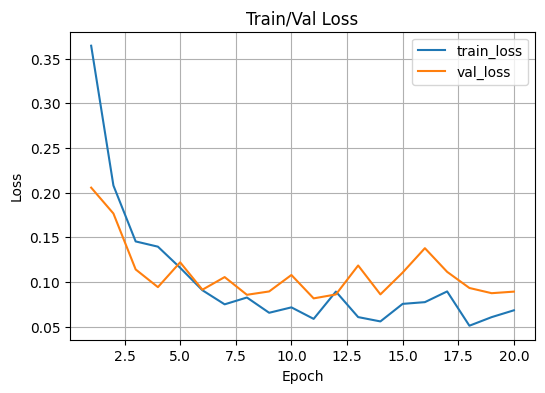

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_history, label="train_loss")
plt.plot(range(1, num_epochs + 1), val_history, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Val Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def denormalize_image(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

In [ ]:
xml_files = full_dataset.xml_files

cat_xml = ROOT_DIR / "cat.0.xml"
dog_xml = ROOT_DIR / "dog.0.xml"

cat_index = xml_files.index(cat_xml)
dog_index = xml_files.index(dog_xml)
print("cat_index:", cat_index, "dog_index:", dog_index)

cat_index: 0 dog_index: 550


In [ ]:
def show_prediction(dataset, index):
    model.eval()
    with torch.no_grad():
        image, bbox_true, label_true = dataset[index]

        img_input = image.unsqueeze(0).to(device)

        logits, bbox_pred = model(img_input)

        probs = torch.softmax(logits, dim=1)[0]
        pred_class_idx = probs.argmax().item()
        pred_label = idx_to_class[pred_class_idx]

        bbox_pred = bbox_pred[0].cpu().numpy()
        pred_bbox_scaled = {
            "xmin": float(bbox_pred[0]),
            "ymin": float(bbox_pred[1]),
            "xmax": float(bbox_pred[2]),
            "ymax": float(bbox_pred[3]),
        }

        img_denorm = denormalize_image(image.to(device)).cpu()
        _, H, W = img_denorm.shape

        pred_bbox_abs = {
            "xmin": pred_bbox_scaled["xmin"] * W,
            "ymin": pred_bbox_scaled["ymin"] * H,
            "xmax": pred_bbox_scaled["xmax"] * W,
            "ymax": pred_bbox_scaled["ymax"] * H,
        }

        show_image_with_bounding_box(
            img_denorm,
            pred_bbox_abs,
            pred_label,
            is_scaled=False
        )

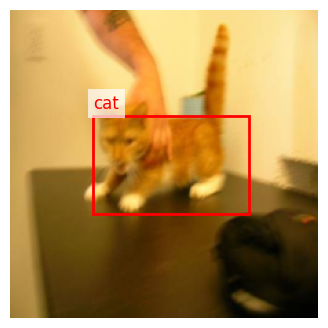

In [ ]:
show_prediction(full_dataset, cat_index)

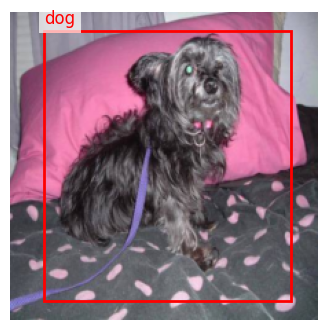

In [ ]:
show_prediction(full_dataset, dog_index)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
CLASS_NAMES = ["cat", "dog"]
def get_cls_predictions(loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, targets, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            logits, bbox_pred = model(images)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [ ]:
def make_confusion_matrix(loader, model, class_names, device, title="Confusion Matrix"):
    preds, true = get_cls_predictions(loader, model, device)
    cm = confusion_matrix(true, preds)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="viridis",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

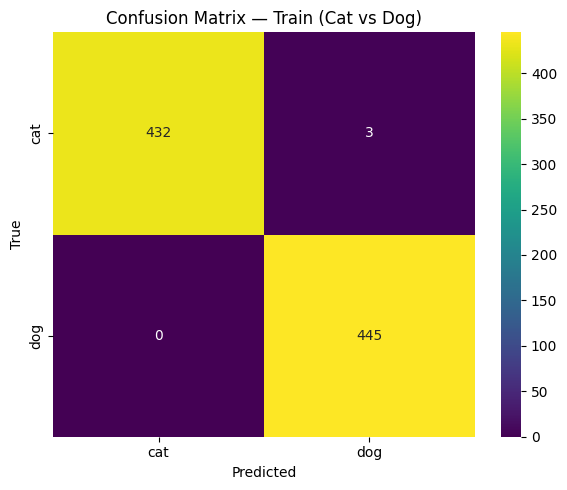

In [ ]:
make_confusion_matrix(train_loader, model, CLASS_NAMES, device,
                      title="Confusion Matrix — Train (Cat vs Dog)")

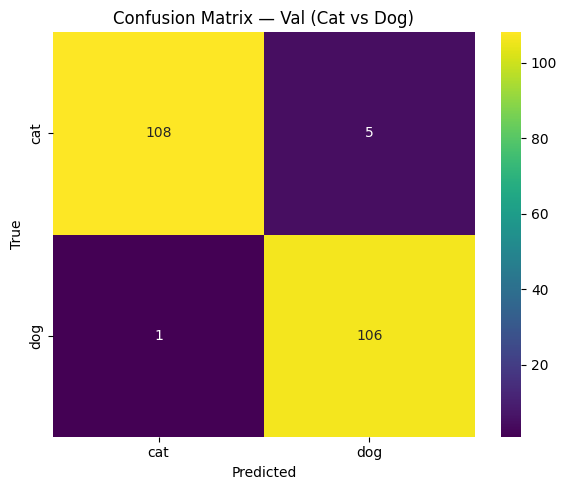

In [ ]:
make_confusion_matrix(val_loader, model, CLASS_NAMES, device,
                      title="Confusion Matrix — Val (Cat vs Dog)")

<p class="task" id="6"></p>

6\. Найдите в сети несколько изображений котов и собак. Используя любой инструмент для разметки (например, [CVAT](https://www.cvat.ai/)), выделите котов и собак на изображениях. Вставьте скриншот экспортированного файла с разметкой. Используя полученные изображения, визуализируйте разметку и bounding boxes, полученные при помощи модели.

- [ ] Проверено на семинаре

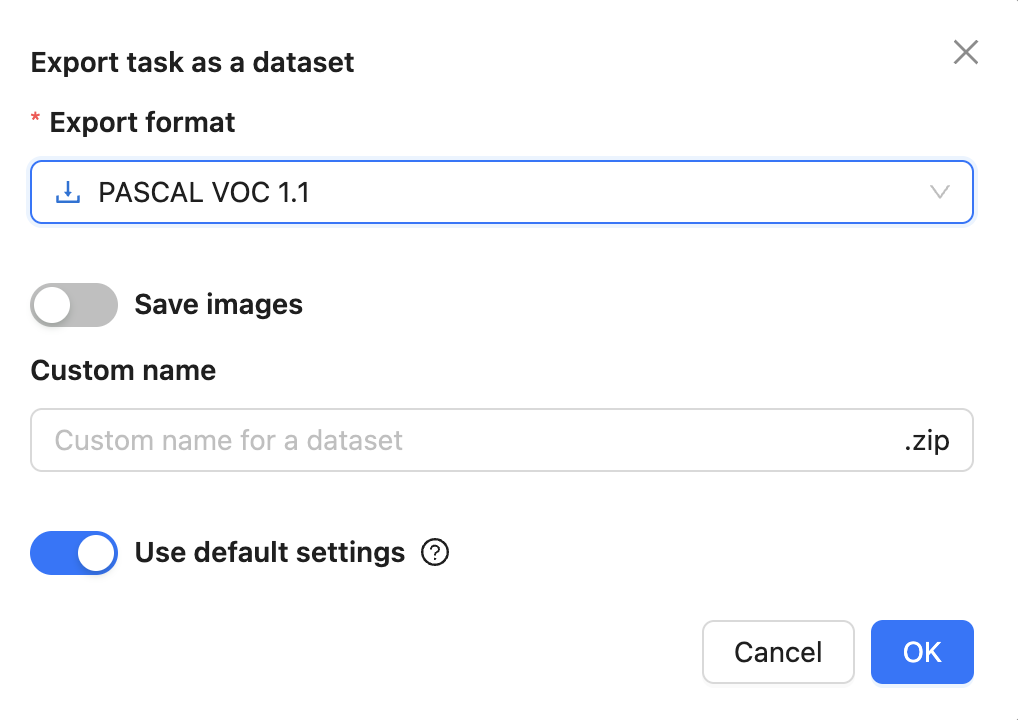

In [ ]:
import zipfile
from pathlib import Path

In [ ]:
BASE_PATH = Path("/content")
KOTI_ZIP_PATH = BASE_PATH / "koti.zip"
KOTI_ROOT = BASE_PATH / "koti_extracted"

KOTI_ROOT.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(KOTI_ZIP_PATH, "r") as z:
    z.extractall(KOTI_ROOT)

print("Содержимое koti_extracted:")
for p in KOTI_ROOT.iterdir():
    print(" -", p)

Содержимое koti_extracted:
 - /content/koti_extracted/labelmap.txt
 - /content/koti_extracted/ImageSets
 - /content/koti_extracted/Annotations


In [ ]:
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
class CvatAnimalDataset(Dataset):
    def __init__(self, root, transforms=None, target_transform=None, return_scaled=True):

        self.root = Path(root)
        self.ann_dir = self.root / "Annotations"
        self.img_dir = self.root / "JPEGImages"

        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled

        self.xml_files = sorted(self.ann_dir.glob("*.xml"))

    def __len__(self):
        return len(self.xml_files)

    def __getitem__(self, idx):
        xml_path = self.xml_files[idx]
        parsed = parse_xml(xml_path)

        bbox = parsed["scaled"] if self.return_scaled else parsed["raw"]

        img_path = self.img_dir / (xml_path.stem + ".jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)
        else:
            image = transforms.ToTensor()(image)

        label = parsed["obj_name"]
        if self.target_transform is not None:
            label = self.target_transform(label)

        return image, bbox, label


In [ ]:
cvat_dataset = CvatAnimalDataset(
    KOTI_ROOT,
    transforms=train_transforms,
    target_transform=lambda name: class_to_idx[name],
    return_scaled=True
)

In [ ]:
print("Размер моего CVAT-датаcета:", len(cvat_dataset))
for i in range(len(cvat_dataset)):
    img, bbox, lab = cvat_dataset[i]
    print(f"Пример {i}: label={idx_to_class[int(lab)]}, bbox={bbox}")

Размер моего CVAT-датаcета: 4
Пример 0: label=dog, bbox={'xmin': 0.16099397590361444, 'ymin': 0.15689843750000002, 'xmax': 0.846495983935743, 'ymax': 0.61790625}
Пример 1: label=cat, bbox={'xmin': 0.1704384133611691, 'ymin': 0.1111796875, 'xmax': 0.9976617954070981, 'ymax': 0.8674687499999999}
Пример 2: label=cat, bbox={'xmin': 0.0, 'ymin': 0.06443169968717413, 'xmax': 0.8375546875, 'ymax': 0.7959645464025027}
Пример 3: label=dog, bbox={'xmin': 0.004149590163934426, 'ymin': 0.12451562499999999, 'xmax': 0.9860143442622951, 'ymax': 0.6655390625}


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

In [ ]:
def show_gt_and_pred(dataset, idx):
    model.eval()
    with torch.no_grad():
        image, bbox_true_scaled, label_true_id = dataset[idx]
        label_true = idx_to_class[int(label_true_id)]

        img_input = image.unsqueeze(0).to(device)

        logits, bbox_pred = model(img_input)

        probs = torch.softmax(logits, dim=1)[0]
        pred_class_idx = probs.argmax().item()
        pred_label = idx_to_class[pred_class_idx]

        bbox_pred_np = bbox_pred[0].cpu().numpy()
        pred_bbox_scaled = {
            "xmin": float(bbox_pred_np[0]),
            "ymin": float(bbox_pred_np[1]),
            "xmax": float(bbox_pred_np[2]),
            "ymax": float(bbox_pred_np[3]),
        }

        img_denorm = denormalize_image(image.to(device)).cpu()
        _, H, W = img_denorm.shape
        img_np = img_denorm.permute(1, 2, 0).numpy()

        gt_bbox_abs = {
            "xmin": bbox_true_scaled["xmin"] * W,
            "ymin": bbox_true_scaled["ymin"] * H,
            "xmax": bbox_true_scaled["xmax"] * W,
            "ymax": bbox_true_scaled["ymax"] * H,
        }

        pred_bbox_abs = {
            "xmin": pred_bbox_scaled["xmin"] * W,
            "ymin": pred_bbox_scaled["ymin"] * H,
            "xmax": pred_bbox_scaled["xmax"] * W,
            "ymax": pred_bbox_scaled["ymax"] * H,
        }

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(img_np)

        ax.add_patch(Rectangle(
            (gt_bbox_abs["xmin"], gt_bbox_abs["ymin"]),
            gt_bbox_abs["xmax"] - gt_bbox_abs["xmin"],
            gt_bbox_abs["ymax"] - gt_bbox_abs["ymin"],
            linewidth=2,
            edgecolor="green",
            facecolor="none",
            label="GT"
        ))

        ax.add_patch(Rectangle(
            (pred_bbox_abs["xmin"], pred_bbox_abs["ymin"]),
            pred_bbox_abs["xmax"] - pred_bbox_abs["xmin"],
            pred_bbox_abs["ymax"] - pred_bbox_abs["ymin"],
            linewidth=2,
            edgecolor="red",
            facecolor="none",
            label="Pred"
        ))

        ax.set_title(f"GT: {label_true}, Pred: {pred_label}")
        ax.axis("off")
        ax.legend()
        plt.show()


Пример 0


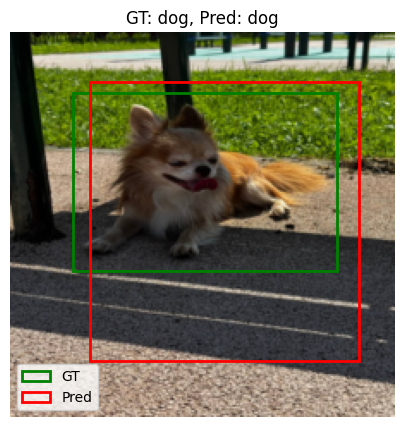

Пример 1


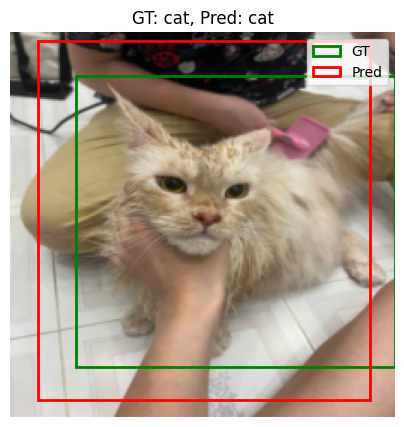

Пример 2


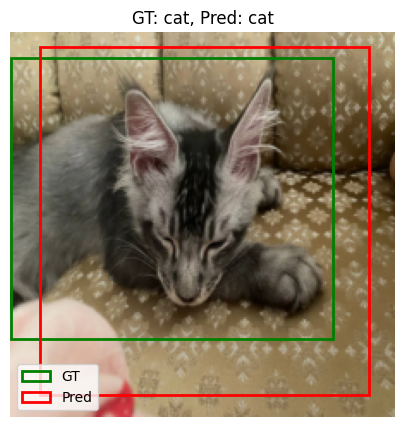

Пример 3


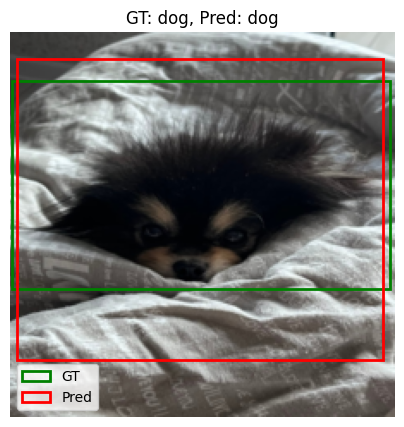

In [ ]:
for i in range(len(cvat_dataset)):
    print(f"Пример {i}")
    show_gt_and_pred(cvat_dataset, i)